In [1]:
# Caveats and Summary
## 1. Go through general steps for data exploration and model training,
## including data visulization, cleaning, looking for correlations,
## customer transformer, feature selection, and model training/testing
##
## 2. This is a quick demo, lots of places can go deeper and explore more.
## for instance, use different methods to quantify correlations between categorical vars,
## and categorical vs continuous, and explore different feature selection methods,
## as well as select/validate models using cross-validation
##
## 3. The challenging of this study is due to missing important factors
## like the info for the driver, which are critical and would be the 
## confounding variables for the current dataset. These are drawbacks, would
## affect the precision of the models directly.
## The advantage of the model is that we take into account various factors,
## and sample the data according to the uneven sample size of Make,
## which is better than making decisions based on the total/average numbers.
## 
## 4. For the last point, there needs better understanding the meaning of input
## variables (like RP State Plate and Location),
## to understand the logical correlation among them, which would help
## to build other useful customized variables.

In [2]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import time
import math

In [3]:
# load data from local disk
df = pd.read_csv('parking_citations.corrupted.csv')

/Users/xbbu/work/recommendation_system/python_362/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (0,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df.head()

,Ticket number,Issue Date,Issue time,Meter Id,Marked Time,RP State Plate,Plate Expiry Date,VIN,Make,Body Style,Color,Location,Route,Agency,Violation code,Violation Description,Fine amount,Latitude,Longitude
0,1103341116,2015-12-21T00:00:00,1251.0,NaN,NaN,CA,200304.0,NaN,NaN,PA,GY,13147 WELBY WAY,01521,1.0,4000A1,NO EVIDENCE OF REG,50.0,99999.0,99999.0
1,1103700150,2015-12-21T00:00:00,1435.0,NaN,NaN,CA,201512.0,NaN,NaN,VN,WH,525 S MAIN ST,1C51,1.0,4000A1,NO EVIDENCE OF REG,50.0,99999.0,99999.0
2,1104803000,2015-12-21T00:00:00,2055.0,NaN,NaN,CA,201503.0,NaN,NaN,PA,BK,200 WORLD WAY,2R2,2.0,8939,WHITE CURB,58.0,6439997.9,1802686.4
3,1104820732,2015-12-26T00:00:00,1515.0,NaN,NaN,CA,NaN,NaN,NaN,PA,WH,100 WORLD WAY,2F11,2.0,000,17104h,NaN,6440041.1,1802686.2
4,1105461453,2015-09-15T00:00:00,115.0,NaN,NaN,CA,200316.0,NaN,CHEV,PA,BK,GEORGIA ST/OLYMPIC,1FB70,1.0,8069A,NO STOPPING/STANDING,93.0,99999.0,99999.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8722030 entries, 0 to 8722029
Data columns (total 19 columns):
Ticket number            object
Issue Date               object
Issue time               float64
Meter Id                 object
Marked Time              float64
RP State Plate           object
Plate Expiry Date        float64
VIN                      object
Make                     object
Body Style               object
Color                    object
Location                 object
Route                    object
Agency                   float64
Violation code           object
Violation Description    object
Fine amount              float64
Latitude                 float64
Longitude                float64
dtypes: float64(7), object(12)
memory usage: 1.2+ GB


In [6]:
df.Make.value_counts()

TOYT    721109
HOND    491747
FORD    382489
NISS    311131
CHEV    296870
BMW     199164
MERZ    177254
VOLK    149467
HYUN    133819
DODG    127683
LEXS    124467
KIA     101679
JEEP    100870
AUDI     84220
MAZD     79832
OTHR     72399
GMC      62357
CHRY     57282
INFI     56767
ACUR     52684
SUBA     46893
VOLV     42313
TOYO     40064
MITS     37824
CADI     34044
MNNI     30881
LNDR     23346
PORS     21923
FRHT     20946
BUIC     20700
         ...  
LOAD         1
ARMO         1
SONA         1
MOLO         1
CHEF         1
CRUM         1
ACCR         1
VERO         1
EL           1
ALPE         1
NEON         1
HPMN         1
LXU          1
UHA          1
CAPR         1
INRI         1
TONE         1
NATH         1
LANR         1
BROU         1
WNSS         1
HIND         1
TROU         1
TORI         1
R/R          1
RAMP         1
CHYC         1
HYTO         1
CHTA         1
SPT          1
Name: Make, Length: 1477, dtype: int64

In [7]:
df.describe()

,Issue time,Marked Time,Plate Expiry Date,Agency,Fine amount,Latitude,Longitude
count,8.719447e+06,290456.000000,7.927596e+06,8.721485e+06,8.715523e+06,8.722027e+06,8.722027e+06
mean,1.203944e+03,1055.316303,1.867813e+05,5.200800e+01,7.010465e+01,5.501964e+06,1.586888e+06
std,4.722259e+02,227.579325,5.276441e+04,9.303553e+00,3.210717e+01,3.004233e+06,2.065862e+06
min,0.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+01,9.999900e+04,9.999900e+04
25%,9.120000e+02,910.000000,2.016010e+05,5.100000e+01,6.300000e+01,6.421513e+06,1.821565e+06
50%,1.156000e+03,1035.000000,2.017020e+05,5.400000e+01,6.800000e+01,6.451530e+06,1.842000e+06
75%,1.511000e+03,1200.000000,2.018030e+05,5.500000e+01,7.300000e+01,6.475013e+06,1.858207e+06
max,2.359000e+03,2400.000000,8.201080e+05,9.700000e+01,5.050000e+02,4.042322e+09,4.042322e+09


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1254fcc88>,
      dtype=object)

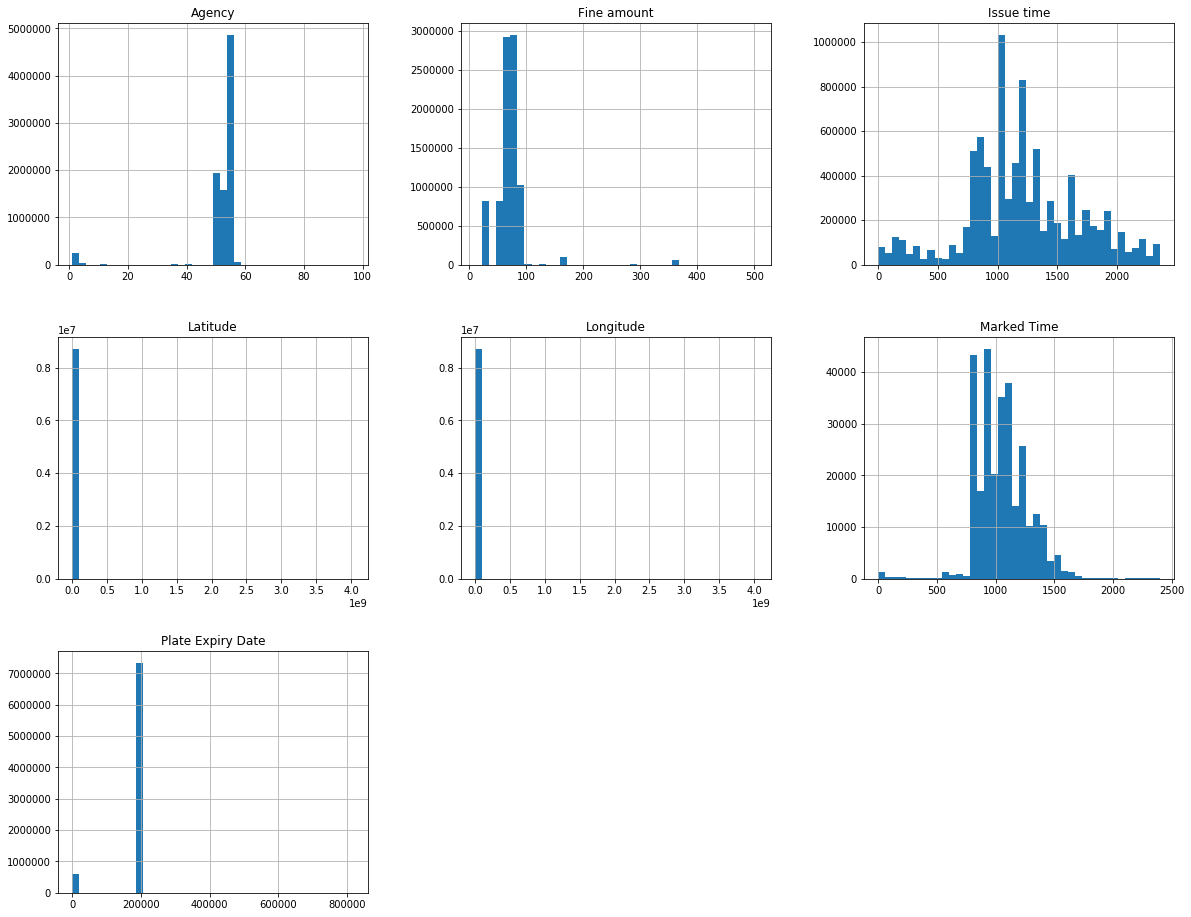

In [8]:
df.hist(bins=40, figsize=(20, 16))

In [9]:
# removing missing values/rows
continuous_vars = ['Fine amount', 'Latitude', 'Longitude']

useless_vars = ['Meter Id', 'Marked Time', 'VIN']

categorical_vars = sorted(set(df.columns))

categorical_vars = [
    ii for ii in categorical_vars if ii not in continuous_vars]

for ivar in useless_vars:
    if ivar in categorical_vars:
        #print(ivar)
        del df[ivar]
        categorical_vars.remove(ivar)
    
for ivar in categorical_vars:
    df[ivar] = df[ivar].apply(lambda x: str(x))
    df = df[df[ivar] != "nan"]    

In [10]:
# keep data for top 25 makes only
top_makes = list(df.Make.value_counts()[:25].index)
df_top = pd.DataFrame(top_makes, columns=['Make'])
df = df_top.merge(df, on='Make', how='inner')

In [11]:
# add a new variable to mark if the plate is expired when get a ticket
# which reflects part info of the driver
df['date_ticket'] = df['Issue Date'].apply(
    lambda x: x.split('T')[0])
def get_date(x):
    x = x.lower().strip()
    x = str(x).split('.')[0]
    if len(x) != 6:
        return 'none'
    x = x[:4] + '-' + x[4:] + '-01'
    return x

df['date_expire'] = df['Plate Expiry Date'].apply(
    lambda x: get_date(x))

print(len(df))
df = df.query('date_expire != "none"')
print(len(df))

df['is_expired'] = df.apply(
    lambda row: 1 if row['date_ticket'] > row['date_expire'] else 0,
    axis=1)

3606565
3353871


In [12]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
from scipy.stats import chi2_contingency, chi2
import re

In [13]:
# use this as example to explore the correlations,
# which is not optimal for categorical variables
label_encoder = LabelEncoder()

In [14]:
for ivar in categorical_vars:
    #if ivar != 'Agency': continue
    ivar_name = re.sub(' ', '_', ivar.lower().strip())
    ivar_label = '{}_label'.format(ivar_name)
    print(ivar_label)
    df[ivar_label] = label_encoder.fit_transform(df[ivar])

agency_label
body_style_label
color_label
issue_date_label
issue_time_label
location_label
make_label
plate_expiry_date_label
rp_state_plate_label
route_label
ticket_number_label
violation_description_label
violation_code_label


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3353871 entries, 0 to 3606564
Data columns (total 32 columns):
Make                           object
Ticket number                  object
Issue Date                     object
Issue time                     object
RP State Plate                 object
Plate Expiry Date              object
Body Style                     object
Color                          object
Location                       object
Route                          object
Agency                         object
Violation code                 object
Violation Description          object
Fine amount                    float64
Latitude                       float64
Longitude                      float64
date_ticket                    object
date_expire                    object
is_expired                     int64
agency_label                   int64
body_style_label               int64
color_label                    int64
issue_date_label               int64
issue_time_labe

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x16e6ea400>,
      dtype=object)

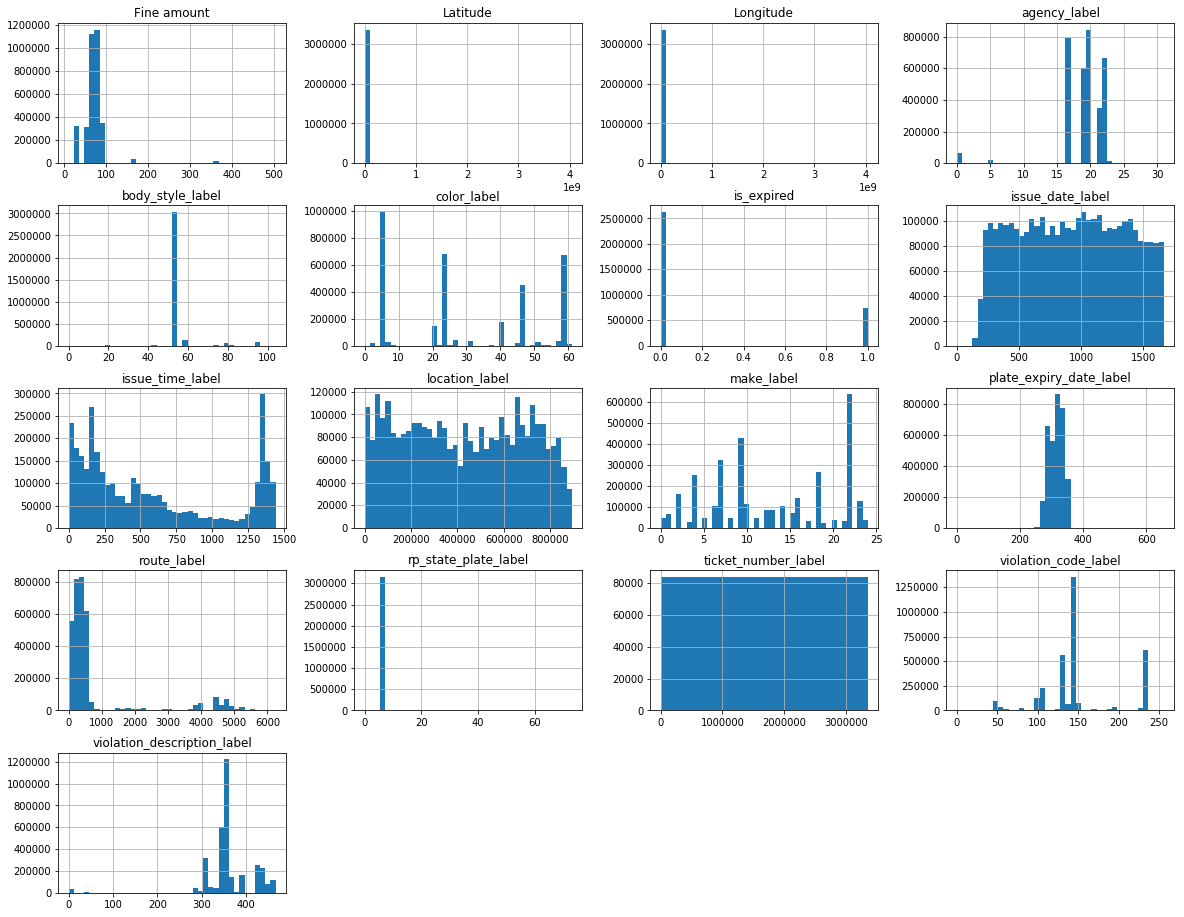

In [16]:
df.hist(bins=40, figsize=(20, 16))

In [17]:
df.corr(method='pearson')['make_label']

Fine amount                    0.011767
Latitude                       0.008053
Longitude                      0.002783
is_expired                    -0.021912
agency_label                   0.022053
body_style_label              -0.072382
color_label                    0.008432
issue_date_label               0.005769
issue_time_label               0.001203
location_label                -0.002059
make_label                     1.000000
plate_expiry_date_label        0.016163
rp_state_plate_label          -0.005952
route_label                   -0.005236
ticket_number_label            0.013072
violation_description_label    0.013487
violation_code_label           0.013921
Name: make_label, dtype: float64

In [18]:
df.corr(method='kendall')['make_label']

Fine amount                    0.014267
Latitude                       0.011234
Longitude                      0.018425
is_expired                    -0.019186
agency_label                   0.006341
body_style_label              -0.075009
color_label                    0.006290
issue_date_label               0.004574
issue_time_label               0.000035
location_label                -0.002250
make_label                     1.000000
plate_expiry_date_label        0.011054
rp_state_plate_label          -0.003299
route_label                   -0.005097
ticket_number_label            0.011917
violation_description_label    0.015483
violation_code_label           0.016536
Name: make_label, dtype: float64

In [19]:
from sklearn.feature_selection import f_classif, mutual_info_classif

In [20]:
# feature selection

In [21]:
set(df.columns)

{'Agency',
 'Body Style',
 'Color',
 'Fine amount',
 'Issue Date',
 'Issue time',
 'Latitude',
 'Location',
 'Longitude',
 'Make',
 'Plate Expiry Date',
 'RP State Plate',
 'Route',
 'Ticket number',
 'Violation Description',
 'Violation code',
 'agency_label',
 'body_style_label',
 'color_label',
 'date_expire',
 'date_ticket',
 'is_expired',
 'issue_date_label',
 'issue_time_label',
 'location_label',
 'make_label',
 'plate_expiry_date_label',
 'route_label',
 'rp_state_plate_label',
 'ticket_number_label',
 'violation_code_label',
 'violation_description_label'}

In [22]:
make_dict = df.set_index('make_label')['Make'].to_dict()

In [23]:
initial_inputs = [
    'Fine amount', 'Latitude', 'Longitude', 'agency_label',
    'body_style_label', 'color_label', 'is_expired',
    'issue_date_label', 'issue_time_label', 'location_label',
    'plate_expiry_date_label', 'route_label', 'rp_state_plate_label',
    'ticket_number_label', 'violation_code_label', 'violation_description_label']

In [24]:
for ivar in ['Fine amount', 'Latitude', 'Longitude']:
    df[ivar] = df[ivar].apply(
        lambda x: -1 if math.isnan(x) else x)
    df = df[df[ivar] > 0.0]

In [25]:
feature_importance_dict = dict(zip(
    initial_inputs,
    mutual_info_classif(df[initial_inputs], df['make_label'])))

In [26]:
# choose top 8 features as example for training model
features_sorted = sorted(
    feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
features_selected = [ii[0] for ii in features_sorted[:8]]

In [27]:
features_selected

['body_style_label',
 'location_label',
 'ticket_number_label',
 'Latitude',
 'Longitude',
 'violation_code_label',
 'color_label',
 'violation_description_label']

In [28]:
from sklearn.model_selection import StratifiedShuffleSplit

In [29]:
# stratified sampling based on the Make category

In [30]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=33)

In [31]:
df = df.reset_index(drop=True)

In [32]:
strat_train_set, strat_test_set = pd.DataFrame(), pd.DataFrame()

for train_index, test_index in split.split(df, df['Make']):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

In [33]:
from sklearn.ensemble import RandomForestClassifier

In [34]:
clf = RandomForestClassifier(n_estimators=100, max_depth=2)

In [35]:
clf_model = clf.fit(
    strat_train_set[features_selected], strat_train_set['make_label'])

In [36]:
# save model
import pickle as pickle
with open('random_forest_classifier.pkl', 'wb') as f:
    pickle.dump(clf_model, f)
    f.close()

In [37]:
from sklearn.metrics import accuracy_score

In [47]:
y_test_true = strat_test_set['make_label'].values
y_test_pred = clf_model.predict(strat_test_set[features_selected].values)
acc_score = accuracy_score(y_test_true, y_test_pred)
print(acc_score)

0.20251967611408492


In [48]:
test_input = [[1, 1, 1, 1, 1, 1, 1, 1]]
clf_model.predict_proba(test_input)

array([[0.01427977, 0.02075512, 0.0536603 , 0.01079132, 0.08301508,
        0.01588101, 0.03576883, 0.10208543, 0.01503226, 0.13094767,
        0.0299093 , 0.01559351, 0.02412999, 0.02428112, 0.01995059,
        0.01878035, 0.03835292, 0.01031154, 0.07932653, 0.0174083 ,
        0.00984693, 0.08353157, 0.09881136, 0.03664639, 0.01090281]])

In [49]:
classes = clf_model.classes_
classes_names = [make_dict[ii] for ii in classes]

In [50]:
dict(zip(classes_names, clf_model.predict_proba(test_input)[0]))

{'ACUR': 0.01427976789790862,
 'AUDI': 0.020755124591984392,
 'BMW': 0.0536602963443789,
 'CADI': 0.010791318525749436,
 'CHEV': 0.08301508161830841,
 'CHRY': 0.015881011255951774,
 'DODG': 0.035768831572521455,
 'FORD': 0.10208542645669297,
 'GMC': 0.015032259479175317,
 'HOND': 0.13094767439554048,
 'HYUN': 0.029909297572599653,
 'INFI': 0.015593505655417585,
 'JEEP': 0.02412998884966195,
 'KIA': 0.02428112124866132,
 'LEXS': 0.01995058937738604,
 'MAZD': 0.018780348215209564,
 'MERZ': 0.03835292337774003,
 'MITS': 0.010311541165244166,
 'NISS': 0.0793265264146516,
 'OTHR': 0.017408296757315547,
 'SUBA': 0.009846928026978502,
 'TOYO': 0.08353157101112098,
 'TOYT': 0.09881136447205428,
 'VOLK': 0.03664639155440188,
 'VOLV': 0.010902814163345107}

In [52]:
# save label transformation to csv file for later model implementation
for ivar in categorical_vars:
    ivar_name = re.sub(' ', '_', ivar.lower().strip())
    ivar_label = '{}_label'.format(ivar_name)
    ivar_dict = df.set_index(ivar)[ivar_label].to_dict()
    print(ivar)
    print(ivar_dict)
    
    df_ivar = pd.DataFrame(columns=[ivar_name, ivar_label])
    df_ivar[ivar_name] = list(ivar_dict.keys())
    df_ivar[ivar_label] = df_ivar[ivar_name].apply(
        lambda x: ivar_dict[x])
    df_ivar.to_csv('{}.csv'.format(ivar_label), index=False)

Agency
{'55.0': 21, '54.0': 20, '56.0': 22, '51.0': 17, '53.0': 19, '57.0': 23, '58.0': 24, '40.0': 12, '1.0': 0, '4.0': 11, '2.0': 5, '11.0': 1, '3.0': 7, '97.0': 31, '36.0': 10, '50.0': 16, '60.0': 26, '5.0': 15, '6.0': 25, '45.0': 14, '77.0': 29, '70.0': 28, '12.0': 2, '24.0': 6, '7.0': 27, '30.0': 8, '35.0': 9, '52.0': 18, '13.0': 3, '41.0': 13, '15.0': 4, '9.0': 30}
Body Style
{'PA': 53, 'PU': 58, 'CM': 20, 'VN': 96, 'TK': 79, 'MH': 44, 'TR': 83, 'SU': 73, 'TT': 84, 'MS': 48, 'OT': 52, 'PP': 56, 'VA': 94, 'VV': 98, 'MC': 43, 'BU': 15, 'GY': 31, 'LM': 42, "'U": 0, 'S': 65, 'BK': 11, 'U': 88, 'UU': 92, '20': 4, 'SC': 67, 'UT': 91, 'MO': 47, '4D': 7, 'SW': 75, 'HO': 36, 'SV': 74, 'UP': 90, 'CR': 23, 'WA': 100, 'CP': 22, '2D': 5, '4W': 10, 'EL': 28, 'RV': 64, 'BX': 16, 'TA': 76, 'SH': 69, 'JE': 39, 'DE': 25, 'CC': 18, 'LI': 41, 'ZV': 103, 'PY': 60, 'DU': 27, 'VT': 97, 'CV': 24, 'CA': 17, 'V9': 93, 'UL': 89, 'EX': 29, 'SE': 68, 'PV': 59, 'CO': 21, 'R': 61, 'G': 30, 'PT': 57, 'HB': 34, 

Issue time
{'1711.0': 501, '1032.0': 39, '1300.0': 217, '1506.0': 365, '1707.0': 497, '1615.0': 444, '1206.0': 152, '909.0': 1389, '1140.0': 119, '1253.0': 204, '1358.0': 280, '1239.0': 188, '1302.0': 219, '1620.0': 449, '1641.0': 470, '809.0': 1328, '1052.0': 61, '1105.0': 80, '1121.0': 98, '1254.0': 205, '815.0': 1334, '813.0': 1332, '1209.0': 155, '1218.0': 165, '1222.0': 170, '1226.0': 174, '1258.0': 209, '854.0': 1373, '857.0': 1376, '859.0': 1378, '918.0': 1398, '256.0': 975, '635.0': 1232, '704.0': 1262, '1728.0': 518, '1935.0': 647, '818.0': 1337, '839.0': 1358, '843.0': 1362, '149.0': 356, '1229.0': 177, '1510.0': 370, '1905.0': 617, '1916.0': 628, '2155.0': 806, '2206.0': 823, '1725.0': 515, '1912.0': 624, '1848.0': 599, '1936.0': 648, '732.0': 1290, '749.0': 1307, '1114.0': 90, '1117.0': 93, '1238.0': 187, '1241.0': 191, '1203.0': 149, '710.0': 1268, '1144.0': 123, '1547.0': 410, '950.0': 1430, '1508.0': 367, '1513.0': 373, '1233.0': 182, '1246.0': 196, '812.0': 1331, '836.0

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Make
{'TOYT': 22, 'HOND': 9, 'FORD': 7, 'NISS': 18, 'CHEV': 4, 'BMW': 2, 'MERZ': 16, 'VOLK': 23, 'HYUN': 10, 'DODG': 6, 'LEXS': 14, 'JEEP': 12, 'KIA': 13, 'MAZD': 15, 'AUDI': 1, 'OTHR': 19, 'GMC': 8, 'CHRY': 5, 'INFI': 11, 'ACUR': 0, 'SUBA': 20, 'VOLV': 24, 'MITS': 17, 'TOYO': 21, 'CADI': 3}
Plate Expiry Date
{'201604.0': 294, '201602.0': 292, '201510.0': 283, '201601.0': 291, '201607.0': 297, '201608.0': 298, '201603.0': 293, '201605.0': 295, '201612.0': 302, '201606.0': 296, '201511.0': 284, '201611.0': 301, '201502.0': 275, '201610.0': 300, '201609.0': 299, '201701.0': 312, '201512.0': 285, '201506.0': 279, '201509.0': 282, '201507.0': 280, '201505.0': 278, '201709.0': 320, '200505.0': 100, '201503.0': 276, '201508.0': 281, '201702.0': 313, '201704.0': 315, '201409.0': 268, '201504.0': 277, '201712.0': 323, '201501.0': 274, '201708.0': 319, '201407.0': 266, '201703.0': 314, '201706.0': 317, '201408.0': 267, '201410.0': 269, '201203.0': 229, '201402.0': 261, '201106.0': 212, '201903.

RP State Plate
{'CA': 7, 'VT': 67, 'IL': 21, 'TX': 61, 'OR': 51, 'NJ': 42, 'WA': 68, 'NY': 47, 'NV': 45, 'AZ': 5, 'UT': 63, 'WI': 69, 'NM': 43, 'CO': 9, 'OK': 49, 'IA': 19, 'MI': 30, 'MT': 34, 'FL': 14, 'MA': 26, 'SD': 58, 'GA': 16, 'PA': 52, 'MO': 32, 'KS': 23, 'MN': 31, 'HI': 18, 'AR': 3, 'CZ': 11, 'TN': 59, 'LA': 25, 'NC': 37, 'IN': 22, 'OH': 48, 'ND': 38, 'MD': 28, 'CT': 10, 'ME': 29, 'RI': 55, 'KY': 24, 'AB': 0, 'MS': 33, 'VA': 64, 'DE': 13, 'AL': 2, 'NE': 39, 'BC': 6, 'NH': 41, 'PE': 53, 'ID': 20, 'AK': 1, 'SC': 57, 'WY': 71, 'ON': 50, 'DC': 12, 'TT': 60, 'WV': 70, 'MX': 35, 'NS': 44, 'MB': 27, 'FN': 15, 'GU': 17, 'SA': 56, 'NB': 36, 'US': 62, 'NF': 40, 'NW': 46, 'CN': 8, 'AS': 4, 'QU': 54, 'VN': 66, 'VI': 65, 'XX': 72, 'YU': 73}
Route
{'00500': 398, '496R1': 4509, '00635': 512, '00543': 439, '00640': 517, '00111': 76, '00394': 292, '00115': 80, '00556': 452, '00454': 352, '00631': 508, '00445': 343, '00672': 549, '00403': 301, '00142': 104, '00319': 223, '00474': 372, '00471': 3

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Violation Description
{'NO STOP/STANDING': 362, 'DISPLAY OF PLATES': 314, 'METER EXP.': 346, 'DISPLAY OF TABS': 315, 'NO PARK/STREET CLEAN': 354, 'PARKED OVER TIME LIM': 393, 'BLK BIKE PATH OR LAN': 285, 'RED ZONE': 435, 'NO PARKING': 355, 'PREFERENTIAL PARKING': 427, 'STOP/STAND PROHIBIT': 451, 'WHITE ZONE': 462, 'STANDNG IN ALLEY': 447, '18 IN. CURB/2 WAY': 11, 'BLOCKING DRIVEWAY': 289, 'NO STOP/STAND': 359, 'DISABLED PARKING/NO': 310, 'NO STOPPING/ANTI-GRI': 363, 'PARKED ON SIDEWALK': 392, 'COMM VEH OVER TIME L': 298, 'FIRE HYDRANT': 330, 'YELLOW ZONE': 467, 'OUTSIDE LINES/METER': 370, 'OFF STR/OVERTIME/MTR': 368, 'RESTRICTED TAXI ZONE': 438, 'TIME LIMIT/CITY LOT': 454, 'DOUBLE PARKING': 317, 'OVNIGHT PRK W/OUT PE': 376, 'PARKED IN BUS ZONE': 386, 'OFF STR MTR/OUT LINE': 367, 'EXCEED 72HRS-ST': 326, 'DISABLED PARKING/CRO': 308, 'PARKED IN CROSSWALK': 387, 'WITHIN INTERSECTION': 463, 'PK OVERSIZ': 413, 'SAFETY ZONE/CURB': 442, '18 IN. CURB/1 WAY': 10, 'GREEN ZONE': 334, 'DISABLED PAR